# TME 9 - Explication de données : clustering

Réalisé par :      
* BENHADDAD Sabrina
* BENSIDHOUM Azzedine

L'objectif de ce TME est d'évaluer et de comparer plusieurs méthodes de clustering à l'image des c-moyennes floues et possibilistes avec d'autres méthodes plus connues telles que les algorithmes de sklearn k-moyennes, clustering spectral, clustering hiérarchique et enfin DBSCAN.



In [1]:
#Imports nécessaires
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import norm, multivariate_normal

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import sklearn.cluster as sc
from sklearn.mixture import GaussianMixture


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True, 'legend.facecolor': 'white'})

##Génération des données - gaussiennes

Pour ce faire, nous allons commencer par générer des données artificielles constituées d'un nombre connu de gaussiennes

In [2]:
data = make_blobs(n_samples = 1000, centers = 3, n_features = 2, cluster_std = 1.5, random_state = 42)

In [3]:
data[0].shape

(1000, 2)

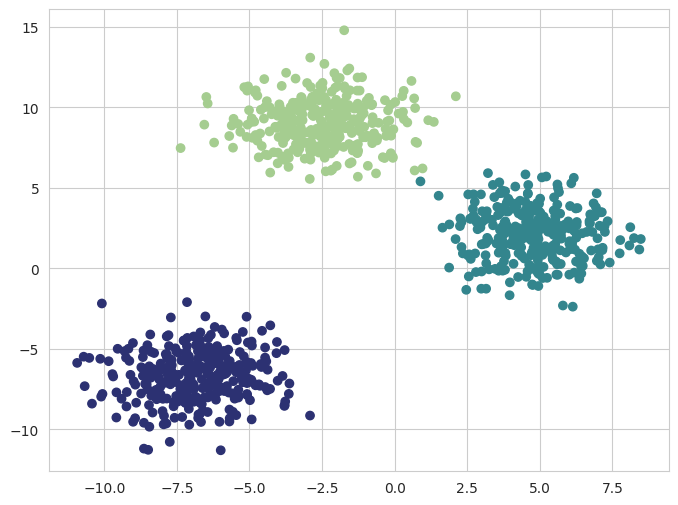

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(data[0][:,0],data[0][:,1], c = data[1], cmap = 'crest')

In [5]:
X = StandardScaler().fit_transform(data[0])

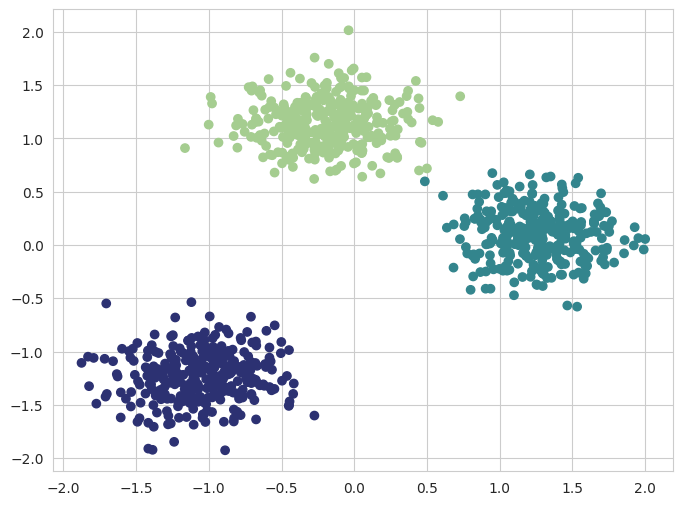

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1], c = data[1], cmap = 'crest')

## 1. Implémentation des algorithmes

In [ ]:
"""Algorithme des fuzzy moyennes marche plutot bien avec des matrices
# X : matrice qui contient les données : xik
# W = matrice des Wik qui contient les centres des clusters
# D = la matrice des distances
# Et enfin la matrice des Uir

#Idée, boucle qui fait la mise à jour, jusqu'à ce que ça converge
"""

### Fuzzy c-means

In [7]:
def fuzzy_c_means(X, c, m=2, epsilon=1e-5):
    """
    Fonction qui permet d'implémenter l'algorithme des c-moyennes floues.

    Entrée :
        - X : n x d - la matrice de données.
        - c : le nombre de clusters recherchés.
        - m : le fuzzifier => le degré de flou de la partition.

    Sortie :
        - W : c x d - matrice contenant centre des clusters.
        - U : n x c - matrice d'affectation des fuzzy clusters.
    """

    n, d = X.shape

    # Initialisation des choix de c centres Wr
    index_centres = np.random.choice(n, c, replace=False)
    W = X[index_centres, :]

    # Initialisation random de la matrice d'affectation U
    #On rajoute le epsilon pour éviter d'avoir un 0
    U = np.random.rand(n, c) + epsilon
    U = U / U.sum(axis=1, keepdims=True)

    cpt = 1
    # Itération : jusqu'à convergence
    while True:
        # MAJ des centres, donc de W
        W = (U.T ** m) @ X / np.sum(U.T ** m, axis=1)[:, np.newaxis]

        # Calcul de la matrice de distance D
        D = np.array([np.linalg.norm(X - w, axis=1) for w in W]).T

        # MAJ de la matrice U
        U_new = 1/ (D ** (2 / (m - 1)))
        U_new /= np.sum(U_new, axis=1)[:, np.newaxis]

        #Calcul de la fonction de coût
        J = 0
        for i in range(n):
          for k in range(c):
            J += (U[i, k] ** m) * np.linalg.norm(X[i, :] - W[k, :]) ** 2

        # Vérification de la convergence
        if np.max(np.abs(U - U_new)) < epsilon:
            print(f"L'algorithme fuzzy converge au bout de {cpt} itérations.\n")
            print("Erreur : ",J)
            print()
            break
        U = U_new
        cpt += 1

    return W, U


In [8]:
fuzzy_c_means(X,3)[0]

L'algorithme fuzzy converge au bout de 13 itérations.

Erreur :  121.75558017972438



array([[-1.06363294, -1.24043425],
       [-0.20628333,  1.13712724],
       [ 1.26391769,  0.09585018]])

L'algorithme fuzzy converge au bout de 14 itérations.

Erreur :  121.75558018542077



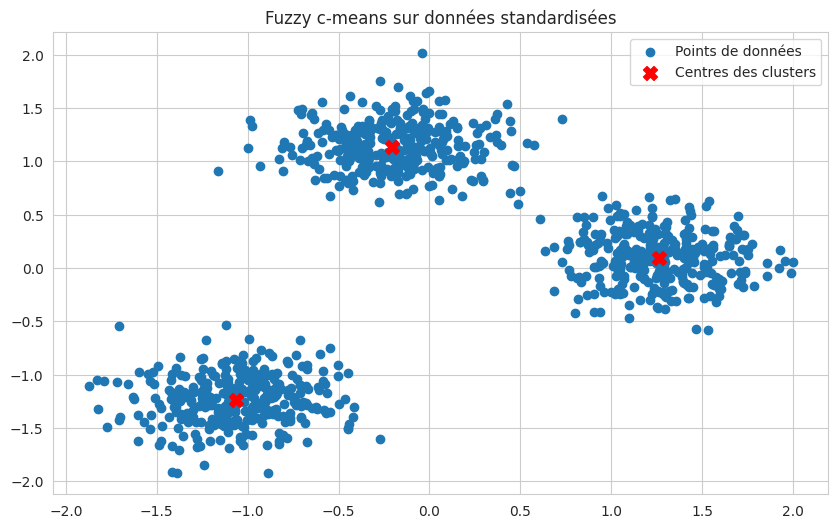

In [9]:
centres, _ = fuzzy_c_means(X, 3)
# Tracé des points de données
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1],label='Points de données')

# Tracé des centres de cluster
plt.scatter(centres[:, 0], centres[:, 1], c='red', marker = 'X', s=100, label='Centres des clusters')

plt.title("Fuzzy c-means sur données standardisées")
plt.legend()
plt.show()

L'algorithme fuzzy converge au bout de 13 itérations.

Erreur :  3962.088931294536



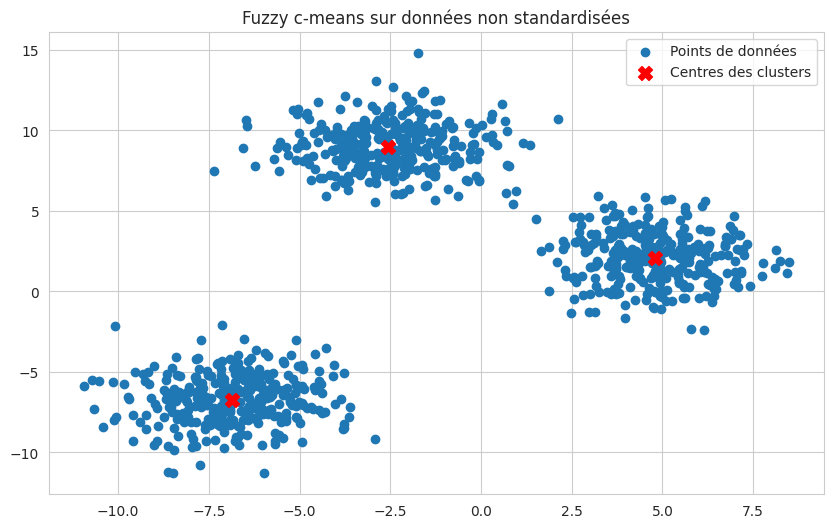

In [10]:
centres, _ = fuzzy_c_means(data[0], 3)

# Tracé des points de données
plt.figure(figsize=(10, 6))
plt.scatter(data[0][:, 0], data[0][:, 1],label='Points de données')

# Tracé des centres de cluster
plt.scatter(centres[:, 0], centres[:, 1], c='red', marker = 'X',s=100, label='Centres des clusters')

plt.title("Fuzzy c-means sur données non standardisées")
plt.legend()
plt.show()

### c-means possibilistes

Même principe que le fuzzy c-means, sauf que dans ce cas, l'équation de la mise à jour de U change, étant donné qu'on introduit un nouveau terme qui permet de récompenser les degrés d'appartenance élevés, et éviter la solution triviale

In [11]:
def c_means_possibilistes(X, c, m=2, epsilon=1e-5):
    n, d = X.shape

    W = fuzzy_c_means(X,c)[0]

    # Initialisation random de la matrice d'affectation U
    U = fuzzy_c_means(X,c)[1]
    # Initialisation de eta
    eta = np.zeros(c)

    cpt = 1
    # Itération : jusqu'à convergence
    while True:
        # MAJ des centres, donc de W
        W = (U ** m).T @ X / np.sum(U ** m, axis=0)[:, np.newaxis]

        # Calcul de la matrice de distance D
        D = np.array([np.linalg.norm(X - w, axis=1) for w in W]).T

        # MAJ de eta pour chaque cluster
        for k in range(c):
          numerator = np.sum((U[:, k] ** m) * (D[:, k] ** 2))
          denominator = np.sum(U[:, k] ** m)
          eta[k] = np.sqrt(numerator / denominator)
        # MAJ de la matrice U
        U_new = np.zeros((n, c))
        for k in range(c):
            dist = np.linalg.norm(X - W[k], axis=1)
            denom = (dist / eta[k]) ** (2 / (m - 1))
            U_new[:, k] = 1 / (1 + denom)

        # Calcul de la fonction de coût
        J = np.sum((U ** m) * (D ** 2)) + np.sum((eta ** 2) * (1 - U) ** m)

       # Vérification de la convergence
        if np.max(np.abs(U - U_new)) < epsilon:
            print(f"L'algorithme possibilistic converge au bout de {cpt} itérations.\n")
            print("Erreur : ", J)
            print()
            break

        U = U_new
        cpt += 1

    return W, U


In [12]:
c_means_possibilistes(X,3)[0]

L'algorithme fuzzy converge au bout de 14 itérations.

Erreur :  121.75558017983329

L'algorithme fuzzy converge au bout de 12 itérations.

Erreur :  121.75558018596992

L'algorithme possibilistic converge au bout de 35 itérations.

Erreur :  99.71898948829698



array([[ 1.23612938,  0.11340393],
       [-1.05856959, -1.26134232],
       [-0.1870311 ,  1.09714394]])

L'algorithme fuzzy converge au bout de 16 itérations.

Erreur :  121.75558017961062

L'algorithme fuzzy converge au bout de 14 itérations.

Erreur :  121.75558018007537

L'algorithme possibilistic converge au bout de 35 itérations.

Erreur :  99.71898947063622



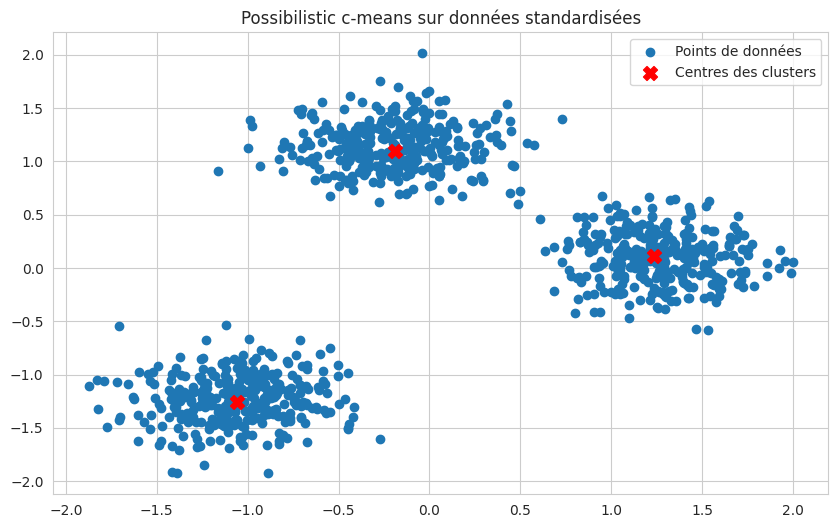

In [13]:
centres, _ = c_means_possibilistes(X, 3)  # Remplacez par votre fonction

# Tracé des points de données
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], label='Points de données')

# Tracé des centres de cluster
plt.scatter(centres[:, 0], centres[:, 1], marker = 'X',c='red', s=100, label='Centres des clusters')

plt.title("Possibilistic c-means sur données standardisées")
plt.legend()
plt.show()

L'algorithme fuzzy converge au bout de 13 itérations.

Erreur :  3962.0889312413783

L'algorithme fuzzy converge au bout de 13 itérations.

Erreur :  3962.088931242559

L'algorithme possibilistic converge au bout de 37 itérations.

Erreur :  3344.4500351661195



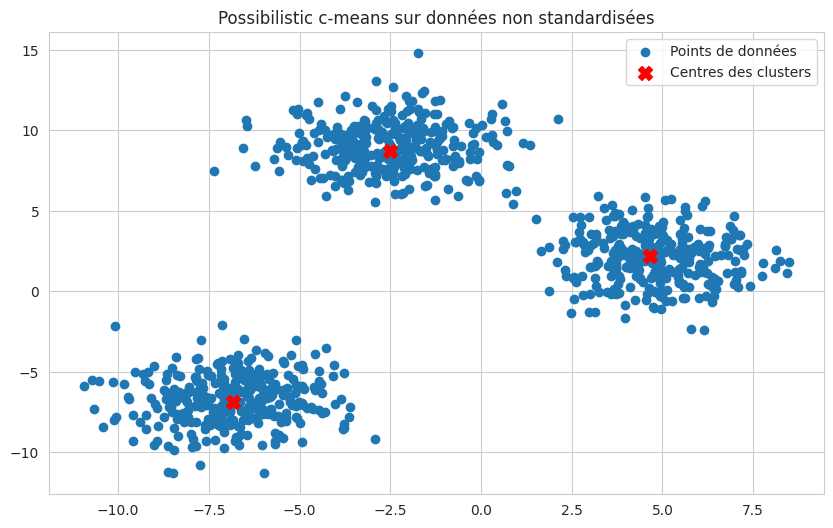

In [14]:
centres, _ = c_means_possibilistes(data[0], 3)  # Remplacez par votre fonction

# Tracé des points de données
plt.figure(figsize=(10, 6))
plt.scatter(data[0][:, 0], data[0][:, 1], label='Points de données')

# Tracé des centres de cluster
plt.scatter(centres[:, 0], centres[:, 1], marker = 'X',c='red', s=100, label='Centres des clusters')

plt.title("Possibilistic c-means sur données non standardisées")
plt.legend()
plt.show()

### Optimisation du code

Dans cette partie, nous allons simplement créer une fonction permettant d'optimiser le code ci-dessous, histoire d'avoir quelque chose de plus propre pour les comparaisons futures

In [15]:
def fcm_pcm(X, c, method, m=2, epsilon=1e-5):
    """
    Fonction qui reprend ce que fait les deux fonctions plus haut
    avec comme paramètre supplémentaire "method" permettant de choisir
    si nous travaillons avec un pcm ou un fcm
    """
    N, _ = X.shape
    cpt = 1
    J = 0

    if method == 'fuzzy':
        index_centres = np.random.choice(N, c, replace=False)
        W = X[index_centres, :]
        U = np.random.rand(N, c) + epsilon
        U = U / U.sum(axis=1, keepdims=True)

        while True:
            W = (U.T ** m) @ X / np.sum(U.T ** m, axis=1)[:, np.newaxis]
            D = np.array([np.linalg.norm(X - w, axis=1) for w in W]).T
            U_new = 1 / (D ** (2 / (m - 1)))
            U_new /= np.sum(U_new, axis=1)[:, np.newaxis]

            # Vérification de la convergence
            if np.max(np.abs(U - U_new)) < epsilon:
              break
            U = U_new
            cpt += 1
    else:
        W = fcm_pcm(X, c, 'fuzzy')[0]
        U = fcm_pcm(X, c, 'fuzzy')[1]
        eta = np.zeros(c)

        while True:
            W = (U ** m).T @ X / np.sum(U ** m, axis=0)[:, np.newaxis]
            D = np.array([np.linalg.norm(X - w, axis=1) for w in W]).T

            for k in range(c):
                numerator = np.sum((U[:, k] ** m) * (D[:, k] ** 2))
                denominator = np.sum(U[:, k] ** m)
                eta[k] = np.sqrt(numerator / denominator)

            U_new = np.zeros((N, c))
            for k in range(c):
                dist = np.linalg.norm(X - W[k], axis=1)
                denom = (dist / eta[k]) ** (2 / (m - 1))
                U_new[:, k] = 1 / (1 + denom)

            # Vérification de la convergence
            if np.max(np.abs(U - U_new)) < epsilon:
              break
            U = U_new
            cpt += 1

    return W, U


In [16]:
fcm_pcm(X,3,'fuzzy')

(array([[-1.06363294, -1.24043425],
        [-0.20628327,  1.13712724],
        [ 1.26391765,  0.09585017]]),
 array([[0.99619954, 0.00195696, 0.0018435 ],
        [0.98323798, 0.00856907, 0.00819295],
        [0.00235929, 0.00505169, 0.99258902],
        ...,
        [0.04204468, 0.2093955 , 0.74855981],
        [0.00784028, 0.01710706, 0.97505266],
        [0.99124088, 0.00471742, 0.00404169]]))

In [17]:
fcm_pcm(X,3,'possibiliste')

(array([[-1.05856959, -1.26134232],
        [-0.1870311 ,  1.09714394],
        [ 1.23612938,  0.11340393]]),
 array([[0.80935402, 0.00653619, 0.00454479],
        [0.4378621 , 0.00744479, 0.00524698],
        [0.00501903, 0.01192556, 0.53733613],
        ...,
        [0.00508901, 0.02813011, 0.07421115],
        [0.0064467 , 0.01574084, 0.44037433],
        [0.54773874, 0.00614756, 0.00390137]]))

## 2. Comparaison de nos implémentations avec les autres algorithmes de clustering

### K-means
On commence par l'algorithme K-means classique de sklearn

In [ ]:
kmeans = sc.KMeans(n_clusters=3).fit(X)
kmeans.labels_

In [19]:
kmeans.cluster_centers_

array([[-1.06160261, -1.23867217],
       [ 1.26231795,  0.09468415],
       [-0.19574893,  1.13744087]])

<ipython-input-20-289772d8ab24>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], label='Points de données', cmap='viridis')


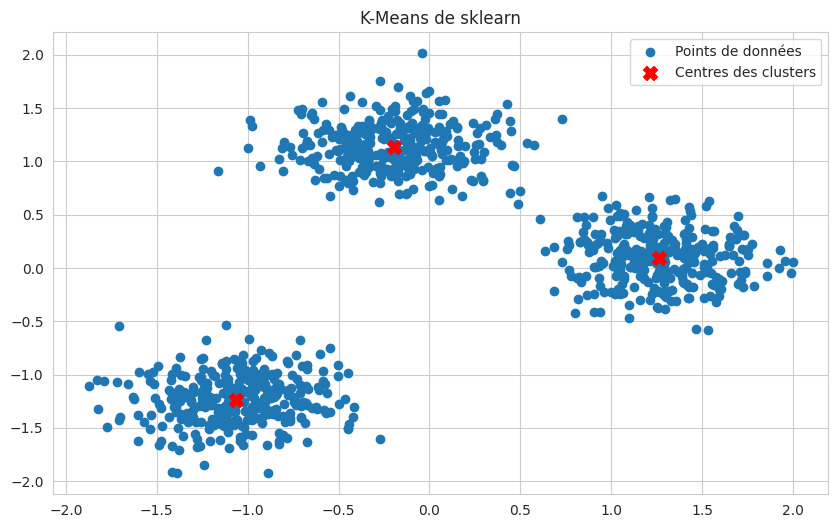

In [20]:
centres = kmeans.cluster_centers_
# Tracé des points de données
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], label='Points de données', cmap='viridis')

# Tracé des centres de cluster
plt.scatter(centres[:, 0], centres[:, 1], marker ='X',c='red', s=100, label='Centres des clusters')

plt.title("K-Means de sklearn")
plt.legend()
plt.axis()
plt.show()

###Clustering Hiérarchique

Le code ci-dessous, pour plot le dendogramme associé à nos données, est fourni dans : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [21]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

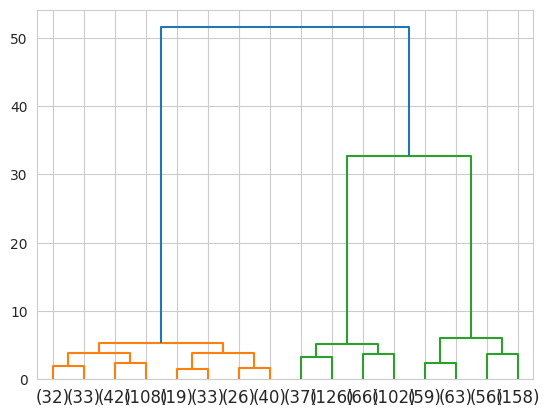

In [22]:
model = sc.AgglomerativeClustering(distance_threshold = 0, n_clusters = None).fit(X)
plot_dendrogram(model, truncate_mode="level", p=3)

### Clustering spectral

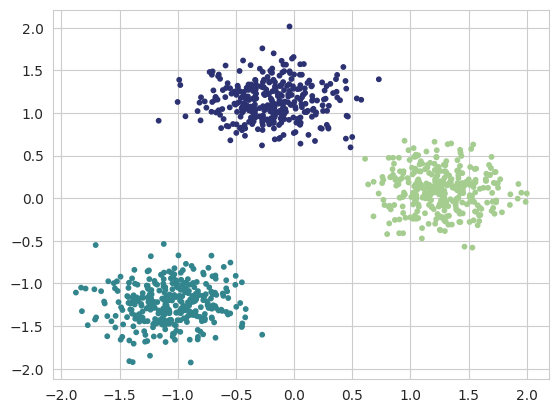

In [23]:
spectral = sc.SpectralClustering(n_clusters = 3).fit(X)
y_pred = spectral.labels_
plt.scatter(X[:,0],X[:,1], s= 10, c = y_pred, cmap = 'crest')

### DBSCAN

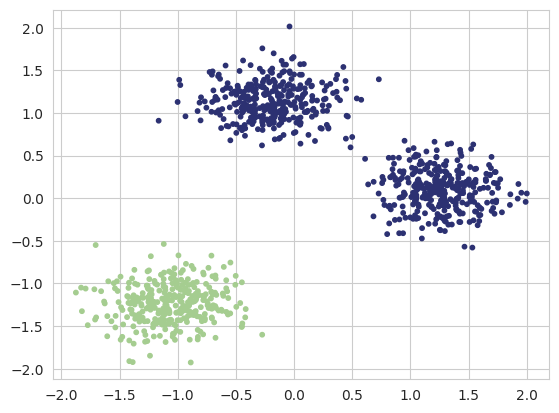

In [24]:
dbscan = sc.DBSCAN().fit(X)
y_pred = dbscan.labels_
plt.scatter(X[:,0],X[:,1], s= 10, c = y_pred, cmap='crest')

### GMM

<ipython-input-25-9b027571e173>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], label='Points de données', cmap='viridis')


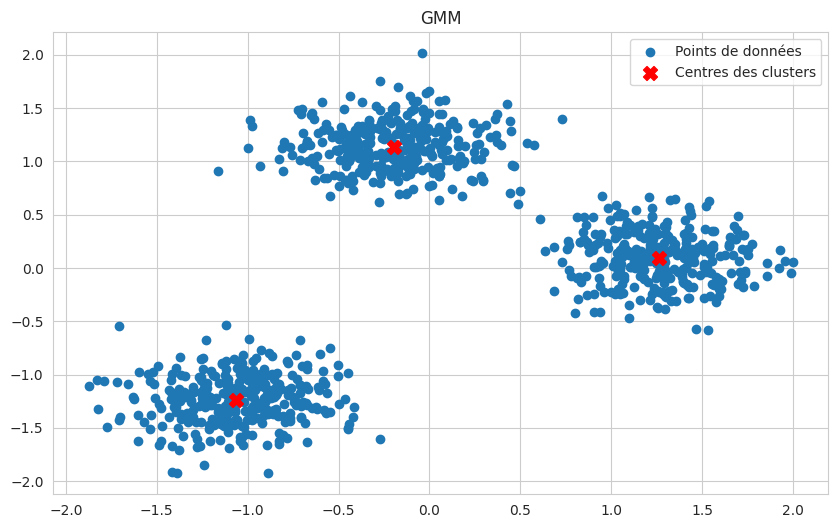

In [25]:
gmm = GaussianMixture(n_components = 3).fit(X)
centres = gmm.means_

# Tracé des points de données
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], label='Points de données', cmap='viridis')

# Tracé des centres de cluster
plt.scatter(centres[:, 0], centres[:, 1], marker = 'X',c='red', s=100, label='Centres des clusters')

plt.title("GMM")
plt.legend()
plt.axis()
plt.show()

### Résumé des résultats obtenus

In [26]:
def plot_clusters(X,c,m=2,alpha=0.5):

  colors = ["darkcyan","midnightblue","darkseagreen","lightgreen", 'orange', 'g']


  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
  # title for entire figure
  fig.suptitle('Résultat des algorithmes de clustering')


  #FCM
  C_fcm,u_fcm = fcm_pcm(X,c,'fuzzy')
  cluster_membership = np.argmax(u_fcm.T, axis=0)
  for j in range(c):
      axes[0, 0].scatter(X.T[0][cluster_membership == j],
                        X.T[1][cluster_membership == j],alpha=alpha,s=50,edgecolors="none",color=colors[j])
  axes[0, 0].set_title('FCM')


  #PCM
  C_pcm,u_pcm= fcm_pcm(X,c,'possibilistic')
  cluster_membership = np.argmax(u_pcm.T, axis=0)

  for j in range(c):
      axes[0, 1].scatter(X.T[0][cluster_membership == j],
                        X.T[1][cluster_membership == j],alpha=alpha,s=50,edgecolors="none",color=colors[j])

  axes[0, 1].set_title('PCM')

  #Kmeans
  kmeans = sc.KMeans(n_clusters=c, random_state=0).fit(X)
  axes[1, 0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=50, alpha=alpha,cmap='crest',edgecolors="none")
  axes[1, 0].set_title('kmeans')

  #GMM
  gm = GaussianMixture(n_components=c, random_state=0).fit(X)
  axes[1, 1].scatter(X[:, 0], X[:, 1], c=gm.predict(X), s=50, alpha=alpha,cmap='crest',edgecolors="none");
  axes[1, 1].set_title('GMM')

  #Spectral
  SC = sc.SpectralClustering(n_clusters=c, affinity='nearest_neighbors', assign_labels='kmeans').fit(X)
  axes[2, 0].scatter(X[:, 0], X[:, 1], c=SC.labels_, s=50, alpha=alpha,cmap='crest',edgecolors="none")
  axes[2, 0].set_title('Spectral')

  #DBSCAN
  db = sc.DBSCAN(eps=0.5, min_samples=5).fit(X)
  axes[2, 1].scatter(X[:, 0], X[:, 1], c=db.labels_, s=50, alpha=alpha,cmap='crest',edgecolors="none")

  axes[2, 1].set_title('DBSCAN')

  plt.savefig("clusters.png")
  plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


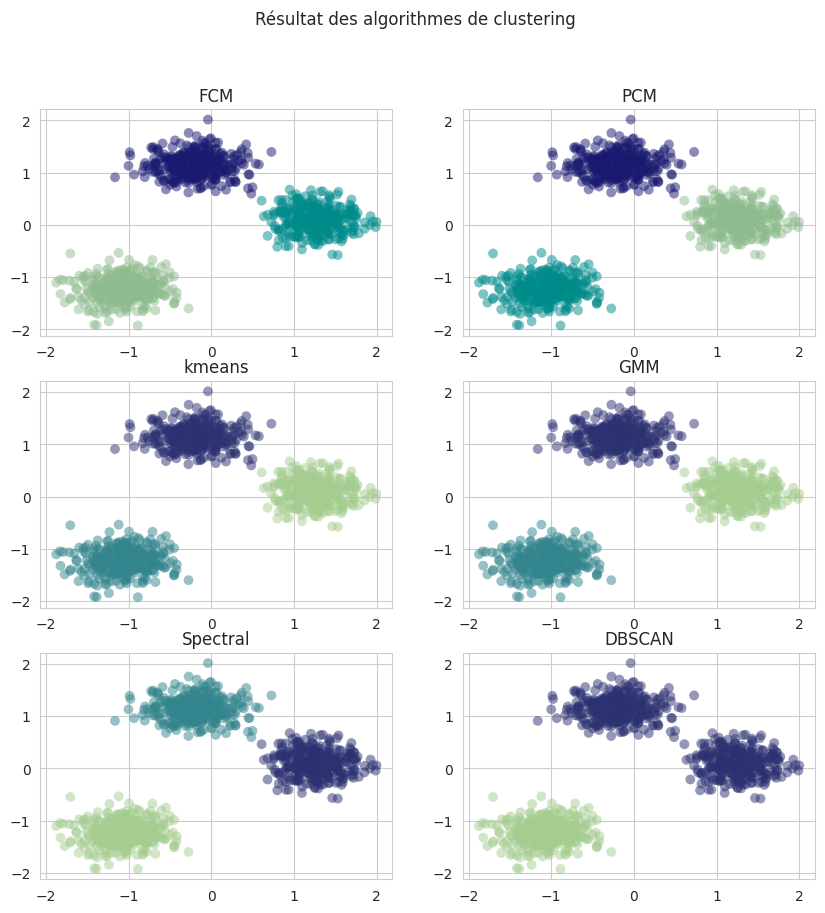

In [27]:
plot_clusters(X,3)

Commentaire :      

En examinant les résultats des différents algorithmes de clustering, tant ceux issus de la bibliothèque scikit-learn que nos implémentations personnalisées du FCM (Fuzzy C-Means) et du PCM (Possibilistic C-Means), nous observons une uniformité dans la performance de la plupart des algorithmes. Le K-means, le GMM (Gaussian Mixture Model), et les méthodes Spectral et nos implémentations FCM/PCM semblent partitionner les données de façon similaire, indiquant une cohérence dans la séparation des groupes malgré des approches algorithmiques distinctes.

Cependant, le DBSCAN se distingue par son approche basée sur la densité, qui dans ce cas spécifique, a abouti à l'amalgamation de deux clusters qui étaient distincts mais géographiquement proches. Cela suggère que, contrairement aux autres méthodes qui se concentrent sur la distance pour définir l'appartenance à un groupe, DBSCAN est particulièrement sensible aux variations de densité, ce qui peut conduire à des résultats de clustering divergents. Cette sensibilité aux paramètres tels que le rayon de voisinage et le nombre minimum de points par cluster doit être prise en compte lors de l'application de DBSCAN pour s'assurer que les clusters sont définis avec précision.

### Variation du paramètre m pour les algorithmes FCM et PCM

Dans cette section, nous allons étudier l'effet du paramètre m **fuzzifier** sur les deux algorithmes PCM et FCM

In [28]:
def plot_var_m(ax, X, cluster_membership, c, title):
  for j in range(c):
    ax.scatter(X.T[0][cluster_membership == j],
                        X.T[1][cluster_membership == j],alpha=0.5,s=50,edgecolors="none",color=colors[j])
    ax.set_title(title)

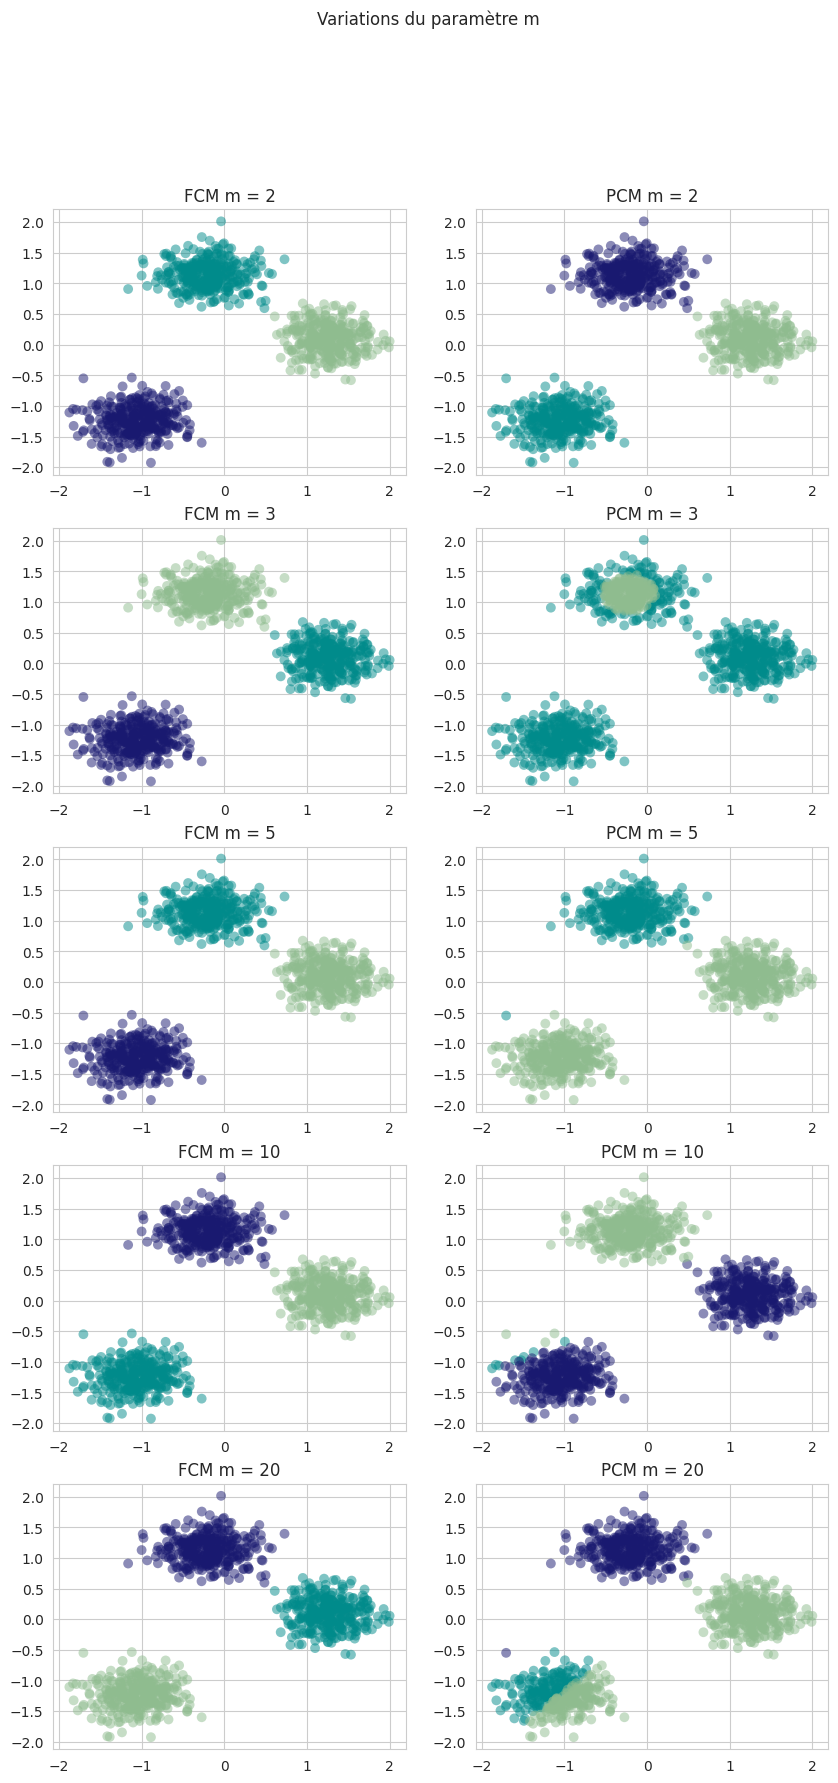

In [34]:
ms = [2,3,5,10,20]
c = 3

colors = ["darkcyan","midnightblue","darkseagreen","lightgreen",'orange', 'g']

fig, axes = plt.subplots(nrows = len(ms), ncols = 2, figsize=(10,20))
fig.suptitle('Variations du paramètre m')


for i, m in enumerate(ms):
  #FCM
  C_fcm,u_fcm = fcm_pcm(X,c,'fuzzy',m)
  cluster_membership = np.argmax(u_fcm.T, axis=0)
  plot_var_m(axes[i,0],X,cluster_membership,c,f'FCM m = {m}')


  #PCM
  C_pcm,u_pcm= fcm_pcm(X,c,'possibilistes',m)
  cluster_membership = np.argmax(u_pcm.T, axis=0)
  plot_var_m(axes[i,1],X, cluster_membership,c, f'PCM m = {m}')

plt.show()

Commentaire :

Le paramètre m, appelé fuzzifier, a un rôle crucial dans la détermination de la façon dont les données sont assignées aux clusters dans le FCM et PCM.

En effet, ce dernier contrôle le niveau de chevauchement entre les clusters, c'est-à-dire, à quel point les clusters seront flous, et influence ainsi la distribution des degrés d'appartenance aux clusters.

Comme nous pouvons le constater, en particulier pour le PCM, plus m est grand, plus les frontières des clusters sont floues, plus les points peuvent appartenir à plusieurs clusters avec des degrés significatifs.

### Affichage des lignes de niveaux
Dans cette section, nous allons tracer les lignes de niveaux des fonctions GMM, PCM et FCM

In [35]:
c = 3
gmm = GaussianMixture(n_components=3, random_state=0,covariance_type = 'full',max_iter = 100).fit(X)
W_fc,_ = fcm_pcm(X, c, method='fuzzy', m=2)
W_pc,_ = fcm_pcm(X, c, method='possibilistic', m=2)

#### A. GMM

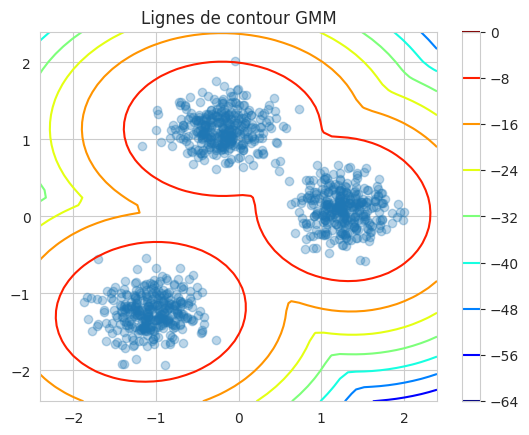

In [36]:
X1, Y = np.meshgrid(np.linspace(-2.4, 2.4), np.linspace(-2.4,2.4))
XX = np.array([X1.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape(X1.shape)
plt.contour(X1, Y, Z,cmap ='jet')
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1],alpha=0.3)
plt.title('Lignes de contour GMM')
plt.show()

In [37]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""

    plt.figure(figsize=(9,6))
    plt.scatter(data[:, 0], data[:, 1], alpha= 0.3)

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 2.0, delta)
    y = np.arange(-2.0, 2.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, cmap='jet')

    plt.title(title)
    plt.tight_layout()

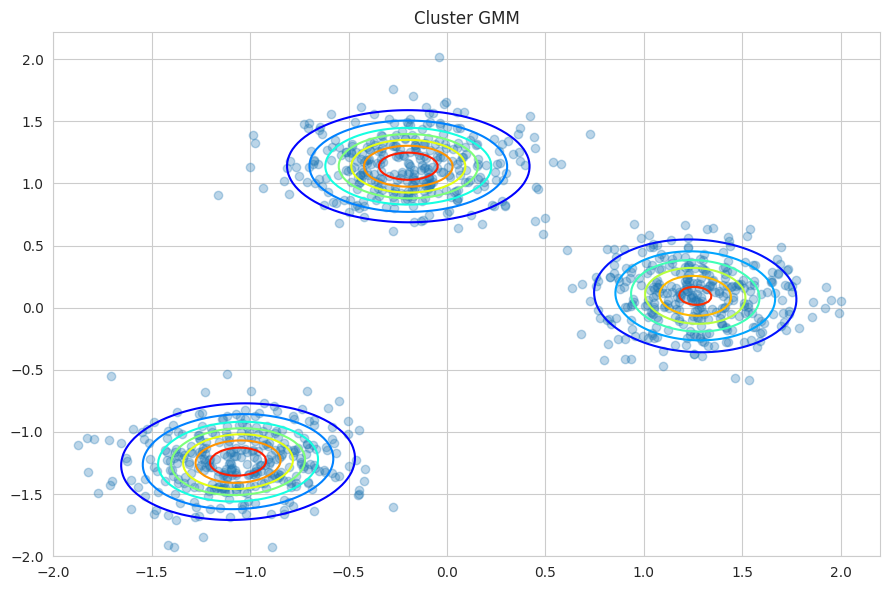

In [38]:
plot_contours(X, gmm.means_, gmm.covariances_, 'Cluster GMM')

#### B. FCM

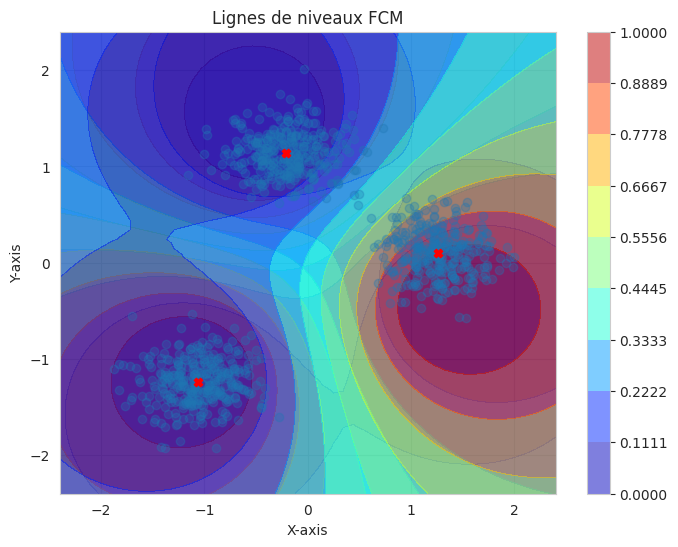

In [61]:
# Créer une grille pour les courbes de niveaux
xx, yy = np.meshgrid(np.linspace(-2.4, 2.4), np.linspace(-2.4, 2.4))
x_grid = np.array([xx.ravel(), yy.ravel()]).T

_, ui_arr = fcm_pcm(x_grid, c=c, method='fuzzy', m=2)

# Reshape the membership array for contour plotting
Z = [ui_arr[:, i].reshape(xx.shape) for i in range(c)]

cmap = 'jet'

plt.figure(figsize=(8, 6))
for i in range(c):
  plt.contourf(xx, yy, Z[i], cmap=cmap, alpha=0.5, levels=np.linspace(Z[i].min(), Z[i].max(), 10))

# Ajout de la colorbar
plt.colorbar()

plt.scatter(X[:, 0], X[:, 1], alpha=0.3)

for center in W_fc:
  plt.scatter(center[0], center[1],marker='X',c='r')

plt.title('Lignes de niveaux FCM')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.show()

#### C.PCM

L'algorithme fuzzy converge au bout de 20 itérations.

Erreur :  2499.1231265087063



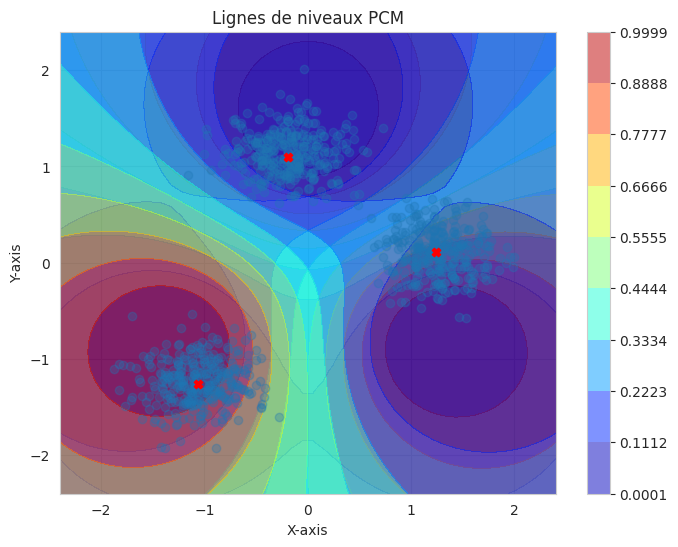

In [62]:
xx, yy = np.meshgrid(np.linspace(-2.4, 2.4), np.linspace(-2.4, 2.4))
x_grid = np.array([xx.ravel(), yy.ravel()]).T
# Calculer les probabilités d'appartenance pour la grille en utilisant PCM
_, U_grid_pcm = fuzzy_c_means(x_grid, c,m=2)

# Reshape des probabilités d'appartenance pour le tracé des contours
Z_pcm = [U_grid_pcm[:, i].reshape(xx.shape) for i in range(c)]

# Tracé des contours
cmap = 'jet'

plt.figure(figsize=(8, 6))
for i in range(c):
    plt.contourf(xx, yy, Z_pcm[i], cmap=cmap,alpha=0.5, levels=np.linspace(Z_pcm[i].min(), Z_pcm[i].max(),10))

# Ajout de la colorbar
plt.colorbar()

# Affichage des points de données et des centres de clusters
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
for center in W_pc:
    plt.scatter(center[0], center[1], marker='X', c='r')

plt.title('Lignes de niveaux PCM')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


## 3. Comparaison des résultats avec des données halfmoons

Dans cette section, nous étudions les algorithmes de clusterings (FCM/PCM et algorithmes de sklearn) sur des données de type **halfmoons** (clusters non gaussiens)

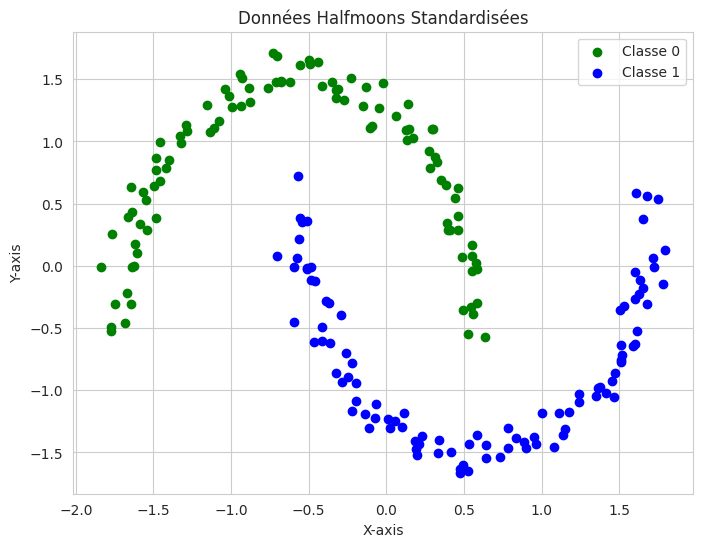

In [63]:
X_moons,y = make_moons(n_samples = 200, noise = 0.05, random_state = 42)
X_std = StandardScaler().fit_transform(X_moons)
plt.figure(figsize=(8, 6))
plt.scatter(X_std[y == 0][:, 0], X_std[y == 0][:, 1], color='green', label='Classe 0')
plt.scatter(X_std[y == 1][:, 0], X_std[y == 1][:, 1], color='blue', label='Classe 1')
plt.title('Données Halfmoons Standardisées')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


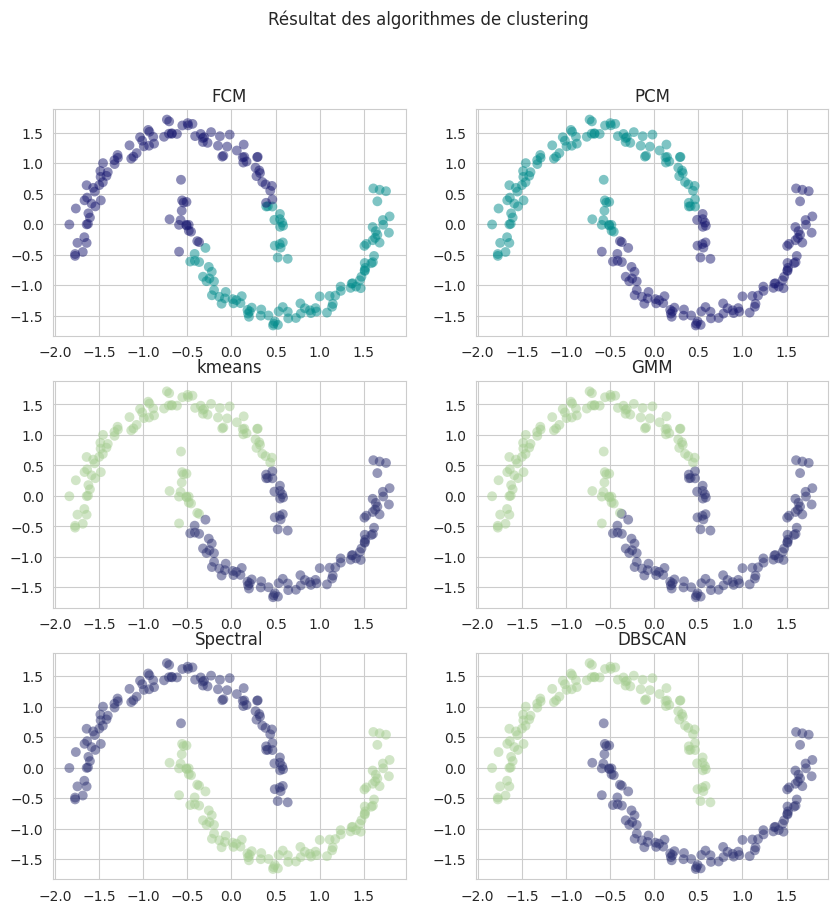

In [65]:
plot_clusters(X_std,2)

Commentaire :     

D'après la visualisation présentée, il est évident que DBSCAN et le clustering spectral se démarquent par leur capacité à identifier correctement les deux clusters distincts dans le jeu de données halfmoon. Contrairement aux autres méthodes testées, ces deux algorithmes ne reposent pas exclusivement sur la distance euclidienne pour définir les clusters. DBSCAN utilise la densité des points, ce qui lui permet de gérer efficacement les clusters de formes irrégulières. Le clustering spectral, quant à lui, se base sur la proximité des points dans un espace de caractéristiques transformé, capturant les structures complexes que les méthodes basées sur la distance ne peuvent discerner. Cela illustre l'importance de choisir une méthode de clustering adaptée à la géométrie intrinsèque des données.

En ce qui concerne les algorithmes FCM et PCM, bien qu'ils n'aient pas réussi à séparer les deux lunes de la même manière que DBSCAN ou le clustering spectral, ils ont tout de même identifié des structures dans les données. Leur performance pourrait être affectée par le choix des paramètres, y compris le paramètre de fuzzification
m.

## 4. Étude de la robustesse des algorithmes par rapport aux exceptions

Pour ce faire, nous allons générer des données artificielles contenant deux clusters sphériques et une exception située à égale distance.

L'objectif étant d'étudier la robustesse des algorithmes face aux exceptions.

In [71]:
X,Y,centres = make_blobs(n_samples = 200, n_features = 2, centers = 2, return_centers = True)

In [72]:
#Générer l'exception
exception = np.array([np.mean(centres[:, 0]), np.mean(centres[:, 1])])

In [73]:
exception

array([-7.78152778, -3.05961635])

Text(0.5, 1.0, 'Données artificielles avec exception')

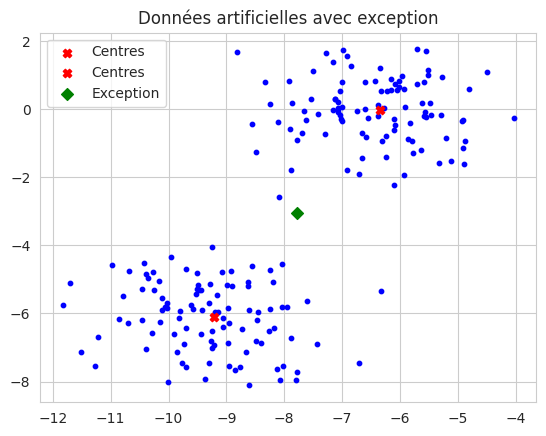

In [74]:
plt.scatter(X[:,0],X[:,1],s = 10, c='b')
for center in centres :
    plt.scatter(center[0], center[1], marker='X', c='r', label = 'Centres')

plt.scatter(exception[0],exception[1], marker = 'D', c = 'g', label = 'Exception')
plt.legend()
plt.title("Données artificielles avec exception")

### A. Ordonnée des centres identifiés en fonction de l'ordonnée de l'exception

In [96]:
def trace_ordonnee_centres(X, centres, range_exception=0.1, steps=20, use_pcm=False):
    # Générer le point d'exception au milieu des centres
    exception = np.array([np.mean(centres[:, 0]), np.mean(centres[:, 1])])

    # Préparer les ordonnées de l'exception et les ordonnées des centres pour les tracés
    ordonnees_exception = np.linspace(exception[1] - range_exception, exception[1] + range_exception, steps)
    ordonnees_centres = np.zeros((steps, centres.shape[0]))

    # Effectuer les expériences
    for i, ordonnee in enumerate(ordonnees_exception):
        # Mettre à jour l'ordonnée du point d'exception
        exception_modifie = np.copy(exception)
        exception_modifie[1] = ordonnee

        # Ajouter l'exception aux données
        X_modifie = np.vstack([X, exception_modifie])

        # Calculer les nouveaux centres avec FCM ou PCM
        if use_pcm:
            nouveaux_centres, _ = fcm_pcm(X_modifie, centres.shape[0], method='possibilistes',m=2)
        else:
            nouveaux_centres, _ = fcm_pcm(X_modifie, centres.shape[0],method='fuzzy', m=2)

        # Stocker les ordonnées des nouveaux centres
        ordonnees_centres[i, :] = nouveaux_centres[:, 1]

    # Tracé
    plt.figure(figsize=(10, 6))
    markers = ['o', 's']
    colors = ['blue', 'orange']
    linestyles = ['--', '-.']
    for j in range(centres.shape[0]):
        plt.plot(ordonnees_exception, ordonnees_centres[:, j], linestyle=linestyles[j], color=colors[j],
                 marker=markers[j], label=f'cluster {j+1}')

    plt.scatter([exception[1]], [exception[1]], color='red', label='Ordonnée exception', zorder=5)
    plt.title('FCM' if not use_pcm else 'PCM')
    plt.xlabel('ordonnée exception')
    plt.ylabel('ordonnée cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

#### FCM

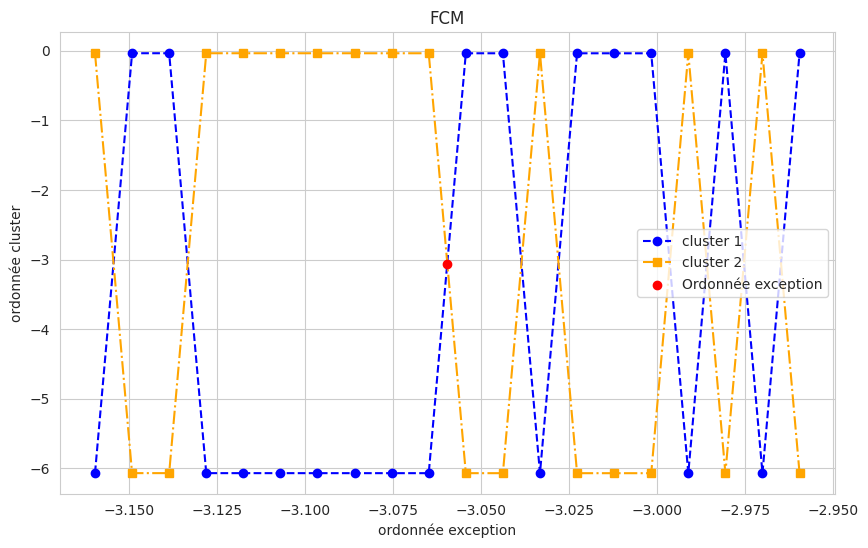

In [97]:
trace_ordonnee_centres(X,centres, use_pcm=False)

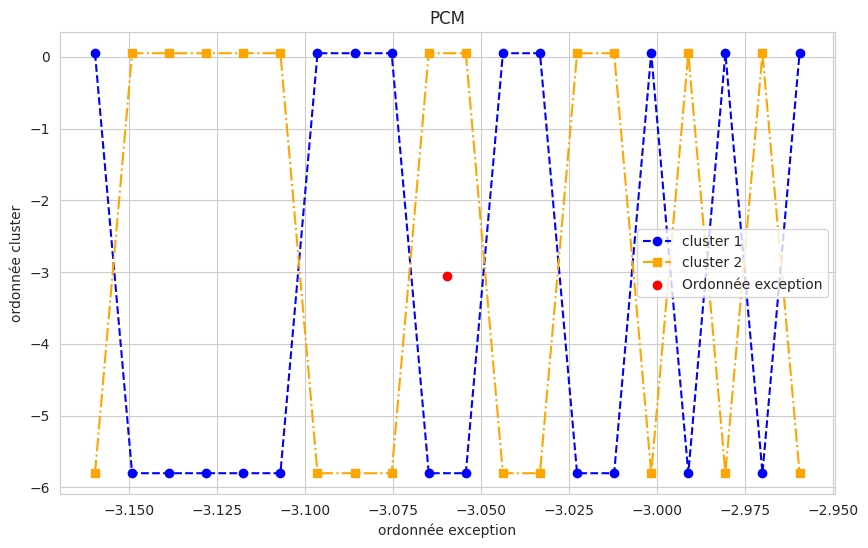

In [98]:
trace_ordonnee_centres(X,centres, use_pcm=True)

Commentaire :

Les visualisations pour les algorithmes FCM et PCM montrent que la présence d'un point de donnée nettement différent des autres, une anomalie ou exception, entraîne un ajustement correspondant dans la position des centres de clusters. Cela révèle que ces méthodes de clustering flou sont sensibles aux variations extrêmes dans l'ensemble de données, ce qui peut influencer la définition des clusters et la classification des points de données environnants.

### B. Ordonnée des centres identifiés en fonction d'un nombre de données situées autour de l'exception


L'objectif étant de tracer l'ordonnée du centre des clusters selon le nombre de points autour de l'exception

In [91]:
def plot_centers_vs_exception_density(X, centers, ts, title="", PCM=False, m=2):
  # Function to get the number of points within a certain threshold distance from eq
  def get_n(X, eq, threshold=2.0):
      return np.sum(np.linalg.norm(X - eq, axis=1) <= threshold)

  # Calculate the exception point as the midpoint between the centers
  eq = np.mean(centers, axis=0)

  # Prepare dictionaries for storing ordinate values for each cluster
  ordinate_clusters = {i: [] for i in range(len(centers))}

  # Define the threshold for considering a point to be around the exception
  thresh = 4.0

  # Iterate over the different translations t
  for t in ts:
      tmp = eq + t
      nb = get_n(X, tmp, thresh)
      tmpX = np.vstack([X, tmp])

      # Call the appropriate clustering function
      if PCM:
          C, _ = fcm_pcm(tmpX, c=2, method='possibilistes', m=m)
      else:
          C, _ = fcm_pcm(tmpX, c=2, method='fuzzy', m=m)

      # Update ordinate values for each cluster
      for i in range(len(centers)):
          ordinate_clusters[i].append((nb, C[i][1]))

  plt.clf()
  # Plot for each cluster
  for i, cluster_data in ordinate_clusters.items():
      cluster_data.sort(key=lambda x: x[0])  # Sort by the number of points around the exception
      n, ordinate = zip(*cluster_data)
      plt.plot(n, ordinate, 'o--', label=f'cluster {i+1}')

  plt.xlabel('Nombre de données autour de e')
  plt.ylabel('ordonnée cluster')
  plt.title(title)
  plt.legend()
  plt.show()

#### FCM

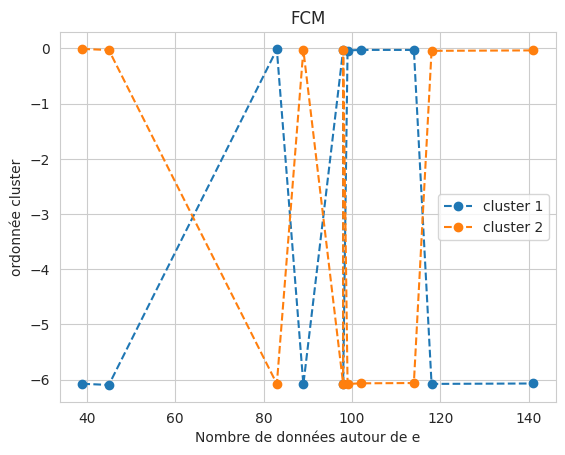

In [95]:
ts  = [-1,-2,-3,-4,-5,0,1,2,3,4,5]
plot_centers_vs_exception_density(X,centres,ts,title="FCM")

#### PCM

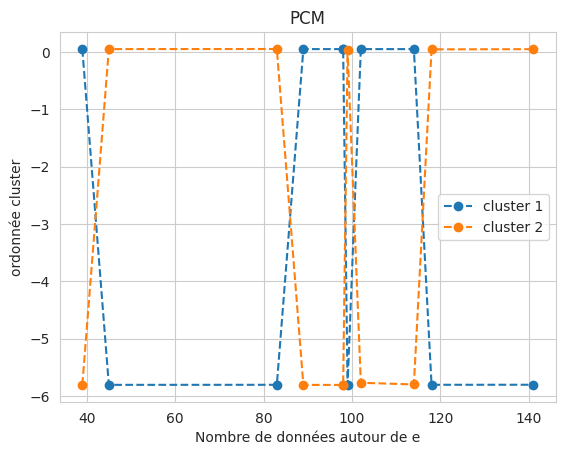

In [94]:
ts  = [-1,-2,-3,-4,-5,0,1,2,3,4,5]
plot_centers_vs_exception_density(X,centres,ts,title="PCM",PCM=True)

Commentaire :

Il est observable que l'algorithme Fuzzy C-Means (FCM) montre une grande sensibilité aux variations du nombre \( n \) de points, tandis que l'algorithme Possibilistic C-Means (PCM) manifeste une stabilité relative face à ces mêmes changements.

## 5. Examiner stabilité des algorithmes par rapport à l'initialisation

Dans cette partie, nous allons examiner la stabilité des algorithmes : leur sensibilité par rapport à une initialisation aléatoire, c'est à dire par rapport à la stratégie d'initialisation.

D'après l'énoncé du TME, seuls les algorithmes KMeans et GMM ont le paramètre **init** permettant de choisir la stratégie d'initialisation.

Bien évidemment, nous testerons également la stabilité du FCM et PCM qui eux aussi, disposent de méthodes d'initialisations différentes.

In [99]:
X, Y = make_blobs(n_samples=200, n_features=2, centers=2)
X = StandardScaler().fit_transform(X)

### A. Kmeans

Dans cette partie, nous allons étudier la stabilité du KMeans par rapport à son initialisation.

Autrement dit, nous allons modifier les deux paramètres : n_clusters et la méthode init

In [100]:
nb_clusters = [2, 3, 4]
init = ['random','k-means++']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

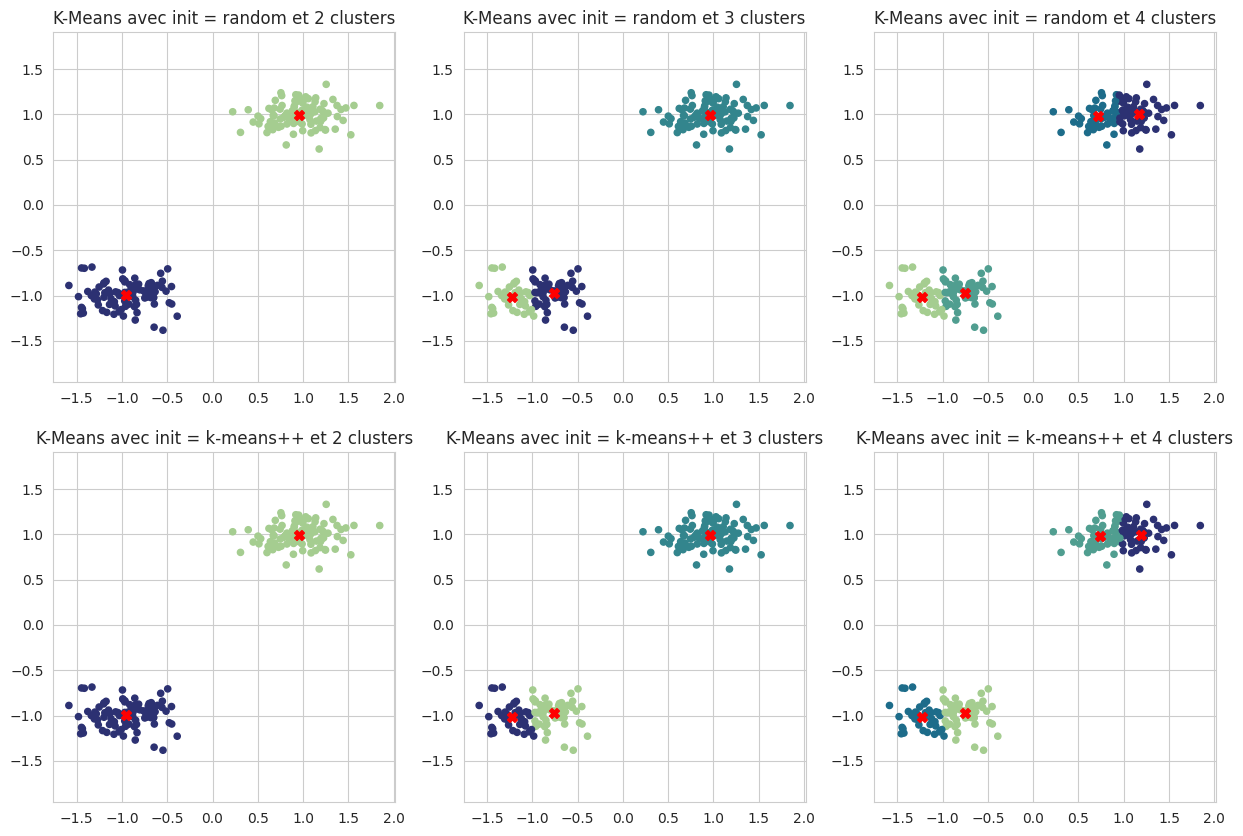

In [101]:
plt.figure(figsize=(15, 10))

# Plot index counter
plot_index = 1

for i in init :
    for c in nb_clusters:

        # KMeans clustering
        kmean = sc.KMeans(n_clusters=c, init=i).fit(X)
        centres = kmean.cluster_centers_

        # Subplot for each combination of initialization method and cluster count
        plt.subplot(len(init), len(nb_clusters), plot_index)
        plt.scatter(X[:, 0], X[:, 1], s=20, c=kmean.labels_, cmap='crest')
        plt.scatter(centres[:, 0], centres[:, 1], marker='X', c='red', s=50)
        plt.title(f"K-Means avec init = {i} et {c} clusters")
        plt.axis('equal')

        # Incrementing plot index
        plot_index += 1

# Showing the entire figure
plt.show()

### B. GMM

Même approche pour cette section

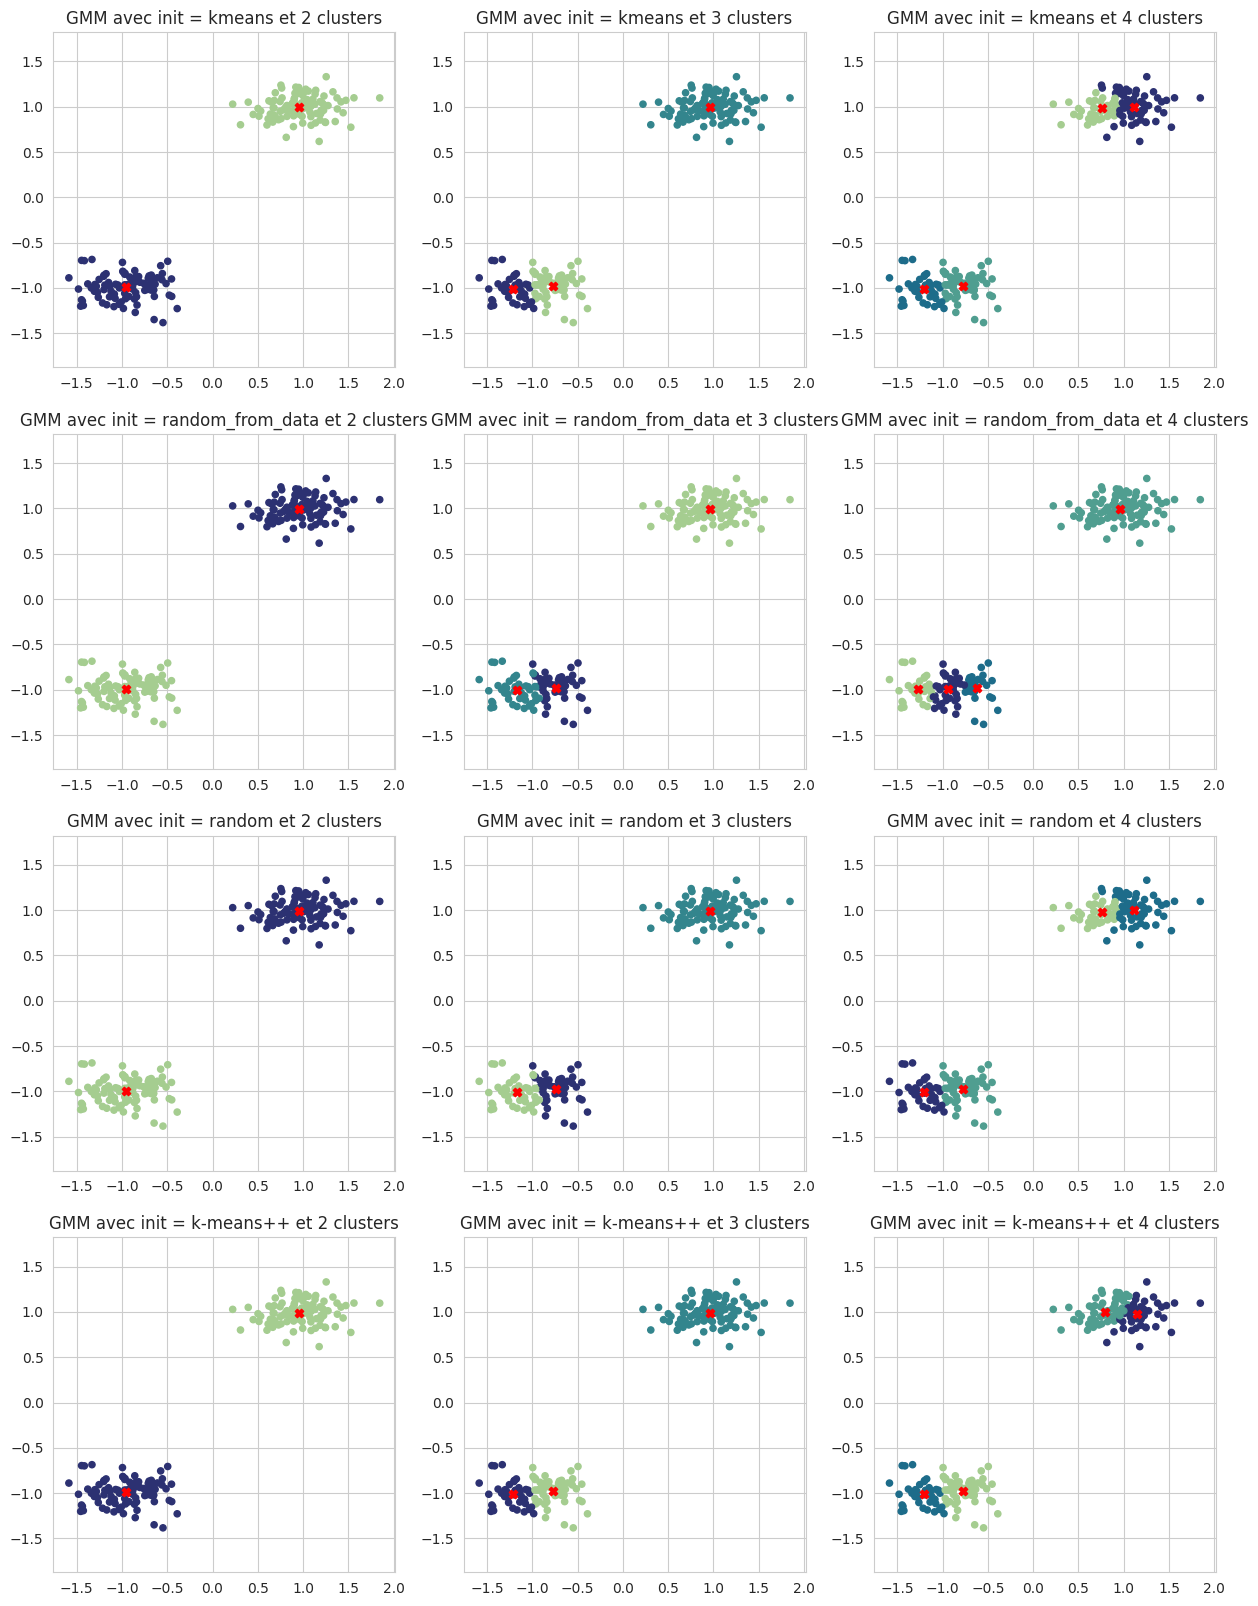

In [102]:
nb_clusters = [2, 3, 4]
init = ['kmeans','random_from_data','random','k-means++']

plt.figure(figsize=(15, 20))

# Plot index counter
plot_index = 1

for i in init :
    for c in nb_clusters:

        gmm = GaussianMixture(n_components = c).fit(X)
        centres = gmm.means_

        # Subplot for each combination of initialization method and cluster count
        plt.subplot(len(init), len(nb_clusters), plot_index)
        plt.scatter(X[:, 0], X[:, 1], s = 20, c=gmm.predict(X), cmap='crest')
        plt.scatter(centres[:, 0], centres[:, 1], marker='X', c='red')
        plt.title(f"GMM avec init = {i} et {c} clusters")

        plt.axis('equal')

        # Incrementing plot index
        plot_index += 1

# Showing the entire figure
plt.show()


### C. FCM

Dans cette section, nous allons tester la méthode d'initialisation **Kmeans++** pour notre FCM

L'initialisation K-Means++ choisit le premier centre de façon aléatoire parmi les points de données, puis les centres suivants sont sélectionnés avec une probabilité proportionnelle au carré de leur distance par rapport au centre le plus proche déjà choisi. Cette méthode favorise une distribution plus uniforme des centres initiaux, ce qui peut améliorer la qualité du clustering final.

In [110]:
def initialize_kmeans(X, num_clusters):
  n_points, d = X.shape
  centers = np.zeros((num_clusters, d))

  # Initialize the first center randomly
  centers[0] = X[np.random.randint(0, n_points)]

  # Initialize the rest of the centers
  for i in range(1, num_clusters):
      # Compute squared distances from the points to the nearest center
      dist_sq = np.array([min([np.inner(c-x, c-x) for c in centers[:i]]) for x in X])
      # Choose the next center with a probability proportional to the squared distance
      probabilities = dist_sq / dist_sq.sum()
      cumulative_probabilities = probabilities.cumsum()
      r = np.random.rand()

      # Find the index of the first cumulative probability greater than r
      for j, p in enumerate(cumulative_probabilities):
          if r < p:
              centers[i] = X[j]
              break

  return centers

In [114]:
def fcm_kmeans(X, c, m=2, epsilon=1e-5):
    N, _ = X.shape
    cpt = 1
    J = 0

    W = initialize_kmeans(X,c)
    U = np.random.rand(N, c) + epsilon
    U = U / U.sum(axis=1, keepdims=True)

    while True:
        W = (U.T ** m) @ X / np.sum(U.T ** m, axis=1)[:, np.newaxis]
        D = np.array([np.linalg.norm(X - w, axis=1) for w in W]).T
        U_new = 1 / (D ** (2 / (m - 1)))
        U_new /= np.sum(U_new, axis=1)[:, np.newaxis]

        # Vérification de la convergence
        if np.max(np.abs(U - U_new)) < epsilon:
          break
        U = U_new
        cpt += 1

    return W,U

Affichage des résultats

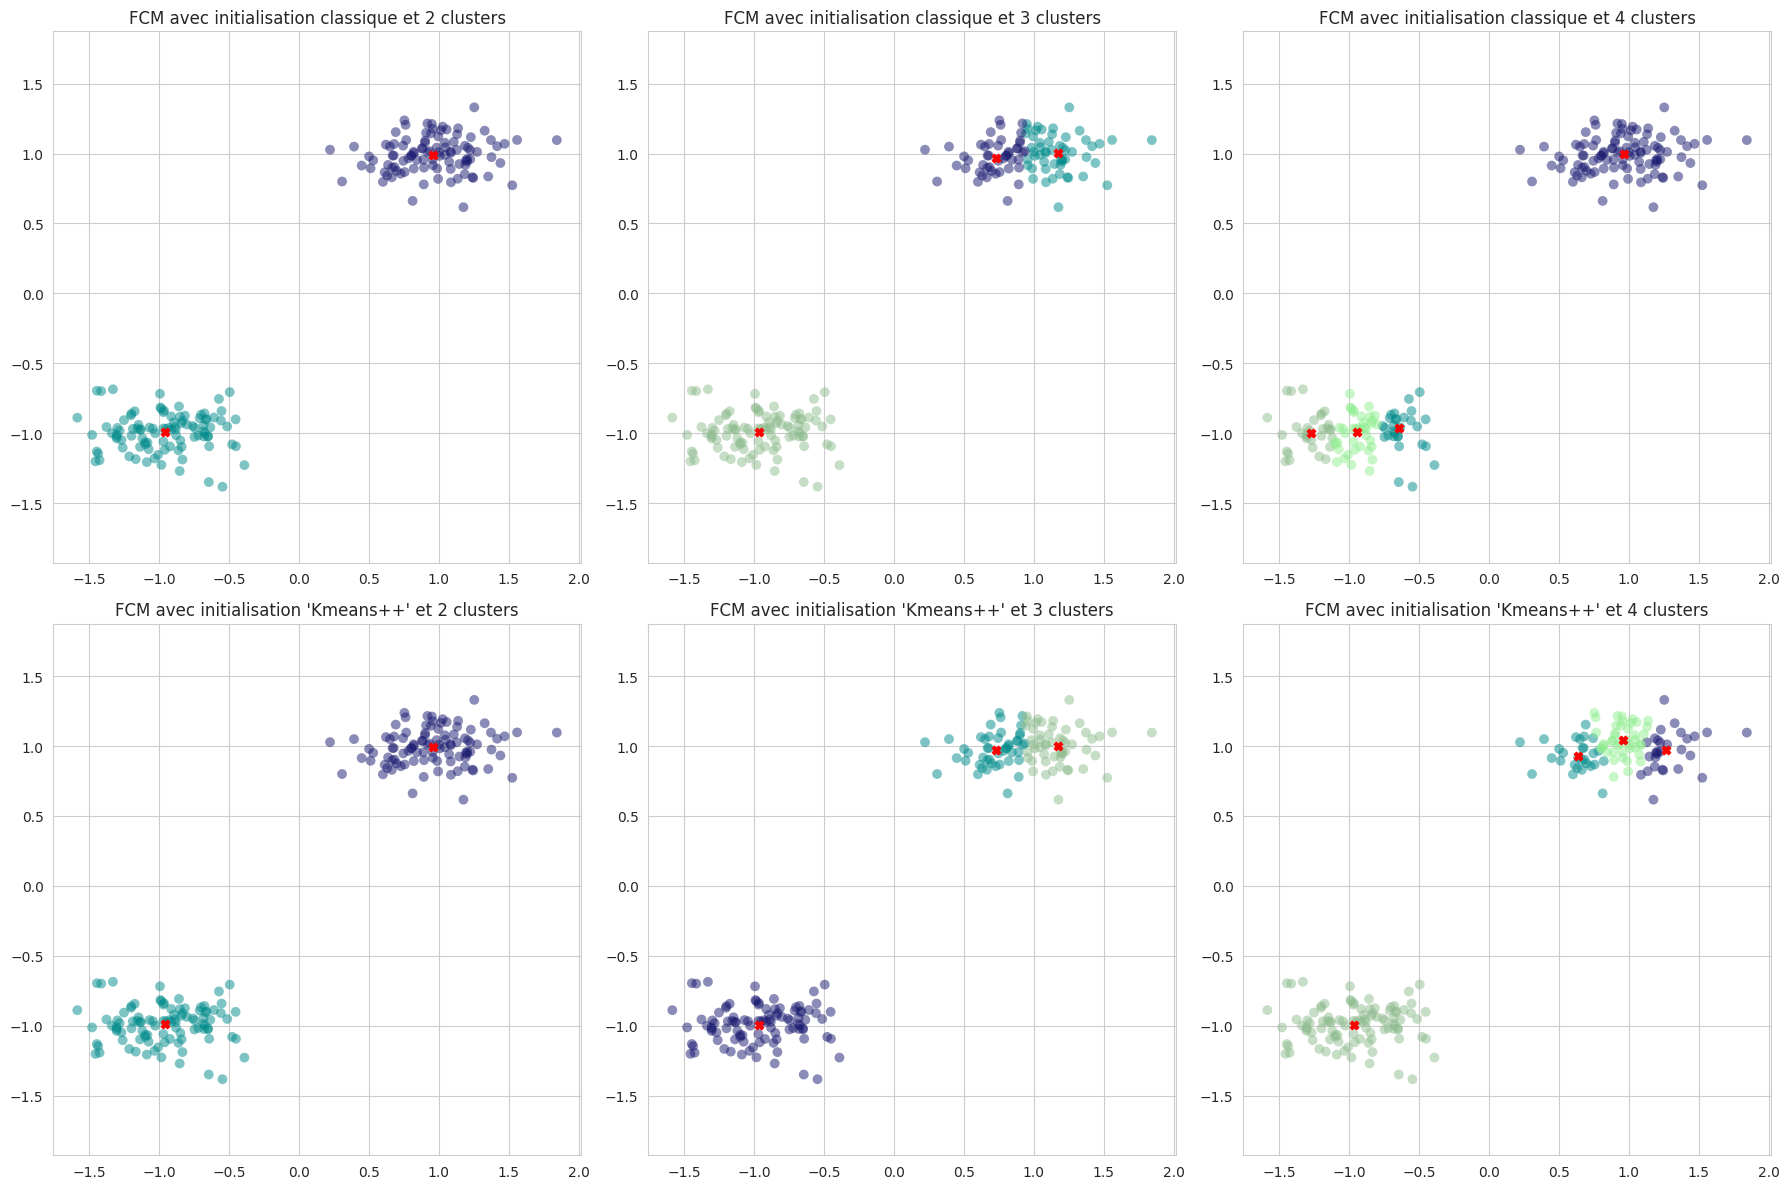

In [149]:
nb_clusters = [2, 3, 4]
colors = ["darkcyan", "midnightblue", "darkseagreen", "lightgreen", "orange", "g"]

# Define the size of the figure
fig_width = 6 * len(nb_clusters)  # Width per plot times the number of plots
fig_height = 6  # Height per plot

# Create a figure with subplots
fig, axes = plt.subplots(2, len(nb_clusters), figsize=(fig_width, 2 * fig_height))

for i, c in enumerate(nb_clusters):
    # FCM with classic initialization
    centres_classic, u_fcm_classic = fcm_pcm(X, c, 'fuzzy')
    cluster_membership_classic = np.argmax(u_fcm_classic.T, axis=0)

    # FCM with Kmeans++ initialization
    centres_kmeans, u_fcm_kmeans = fcm_kmeans(X, c)
    cluster_membership_kmeans = np.argmax(u_fcm_kmeans.T, axis=0)

    # Select the current subplots
    ax_classic = axes[0, i]
    ax_kmeans = axes[1, i]

    for j in range(c):
        # Classic Initialization
        ax_classic.scatter(
            X.T[0][cluster_membership_classic == j],
            X.T[1][cluster_membership_classic == j],
            alpha=0.5,
            s=50,
            edgecolors="none",
            color=colors[j]
        )

        # Kmeans++ Initialization
        ax_kmeans.scatter(
            X.T[0][cluster_membership_kmeans == j],
            X.T[1][cluster_membership_kmeans == j],
            alpha=0.5,
            s=50,
            edgecolors="none",
            color=colors[j]
        )

    ax_classic.scatter(centres_classic[:, 0], centres_classic[:, 1], marker='X', c='red')
    ax_kmeans.scatter(centres_kmeans[:, 0], centres_kmeans[:, 1], marker='X', c='red')

    ax_classic.set_title(f"FCM avec initialisation classique et {c} clusters")
    ax_kmeans.set_title(f"FCM avec initialisation 'Kmeans++' et {c} clusters")

    ax_classic.axis('equal')
    ax_kmeans.axis('equal')

# Adjust layout and show the entire figure
plt.tight_layout()
plt.show()
